# Задание 1

# Выгружаем датасет

In [1]:
import kagglehub
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
df = pd.read_csv('BMW sales data (2010-2024) (1).csv')

# Произведем предварительный анализ датасета

Посмотрим на концепт данных, хранящихся в датасете

In [2]:
df.head()

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


Посмотрим размер нашего датасета и название колонок

In [3]:
df.shape

(50000, 11)

In [4]:
df.columns

Index(['Model', 'Year', 'Region', 'Color', 'Fuel_Type', 'Transmission',
       'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume',
       'Sales_Classification'],
      dtype='object')

In [5]:
df.dtypes

Model                    object
Year                      int64
Region                   object
Color                    object
Fuel_Type                object
Transmission             object
Engine_Size_L           float64
Mileage_KM                int64
Price_USD                 int64
Sales_Volume              int64
Sales_Classification     object
dtype: object

In [6]:
for name in df.columns:
  print(f"{name} :  {df[name].unique()}")

Model :  ['5 Series' 'i8' 'X3' '7 Series' 'M5' '3 Series' 'X1' 'M3' 'X5' 'i3' 'X6']
Year :  [2016 2013 2022 2024 2020 2017 2014 2019 2012 2015 2011 2021 2023 2010
 2018]
Region :  ['Asia' 'North America' 'Middle East' 'South America' 'Europe' 'Africa']
Color :  ['Red' 'Blue' 'Black' 'Silver' 'White' 'Grey']
Fuel_Type :  ['Petrol' 'Hybrid' 'Diesel' 'Electric']
Transmission :  ['Manual' 'Automatic']
Engine_Size_L :  [3.5 1.6 4.5 1.7 2.1 1.9 1.8 3.  2.4 3.8 2.3 2.6 3.1 3.7 4.8 3.3 3.2 2.2
 4.1 2.  4.7 4.3 4.  3.6 4.9 3.4 2.8 3.9 1.5 4.2 2.5 2.7 4.6 5.  4.4 2.9]
Mileage_KM :  [151748 121671  10991 ... 147396   3379 171003]
Price_USD :  [ 98740  79219 113265 ...  73173  48714  77492]
Sales_Volume :  [8300 3428 6994 ... 8743 4398 4341]
Sales_Classification :  ['High' 'Low']


Преобразуем в категориальный признак размер двигателя, разбив на равные классы.

In [7]:
engine_numeric = df['Engine_Size_L'].copy()
df['Engine_Size_L'] = pd.cut(engine_numeric, bins = 4, labels = ['Small', 'Medium', 'Large', 'Very_Large'])
df['Engine_Size_L'] = df['Engine_Size_L'].astype(str)
binned = pd.cut(engine_numeric, bins = 4)
print(binned.cat.categories)

IntervalIndex([(1.496, 2.375], (2.375, 3.25], (3.25, 4.125], (4.125, 5.0]], dtype='interval[float64, right]')


Посмотрим информацию о датасете.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Model                 50000 non-null  object
 1   Year                  50000 non-null  int64 
 2   Region                50000 non-null  object
 3   Color                 50000 non-null  object
 4   Fuel_Type             50000 non-null  object
 5   Transmission          50000 non-null  object
 6   Engine_Size_L         50000 non-null  object
 7   Mileage_KM            50000 non-null  int64 
 8   Price_USD             50000 non-null  int64 
 9   Sales_Volume          50000 non-null  int64 
 10  Sales_Classification  50000 non-null  object
dtypes: int64(4), object(7)
memory usage: 4.2+ MB


Посмотрим предварительную статистику датасета.

In [9]:
df.describe()

,Year,Mileage_KM,Price_USD,Sales_Volume
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,2017.015700,100307.203140,75034.600900,5067.514680
std,4.324459,57941.509344,25998.248882,2856.767125
min,2010.000000,3.000000,30000.000000,100.000000
25%,2013.000000,50178.000000,52434.750000,2588.000000
50%,2017.000000,100388.500000,75011.500000,5087.000000
75%,2021.000000,150630.250000,97628.250000,7537.250000
max,2024.000000,199996.000000,119998.000000,9999.000000


# Поработаем с пропусками и искажениями

Посмотрим наличие пропусков внутри нашего датасета:

In [10]:
df.isnull().any().any()

np.False_

Создадим функции, которые будут вносить в наши данные пропуски и два типа искажений: выбросы и дубликаты.

In [11]:
def missing(df, value):
    df_broken = df.copy()

    #бежим циклом по колонкам
    for col in df.columns:
        #ищем число индексов с пропусками
        n_missing = int(len(df) * value)
        missing_indices = np.random.choice(df.index, n_missing, replace = False)

        # добавляем пропуски
        df_broken.loc[missing_indices, col] = np.nan
    return df_broken

def outliers(df, value):
    df_broken = df.copy()
    #рассмотрим столбцы только числовыми данными, при этом исключив год, тип топлива и двигатель,
    #так как выброса ожидать данных у категориальных числовых переменных будет странно
    numeric_cols = df_broken.drop(columns = ['Year']).select_dtypes(include = [np.number]).columns
    #подбираем множители для появления выбросов
    multiplier = np.random.choice([5, 0.02, 3, 0.007])

    #бежим циклом по колонкам
    for col in numeric_cols:
      #ищем число индексов с выбросами
      n_outliers = int(len(df) * value)
      outlier_indices = np.random.choice(df.index, n_outliers, replace = False)

      #пробегаем по найденным индексам
      for idx in outlier_indices:
          #если в ячейке не nan, то умножаем его на какой-то множитель
          if not pd.isna(df.loc[idx, col]):
                df_broken.loc[idx, col] = df.loc[idx, col] * multiplier
    return df_broken

def data_breaker(df, value):
    np.random.seed(value)
    random.seed(value)

    corruption_types = {
        #пропусков
        'misses': 0.02,
        #выбросов
        'outliers': 0.05,
    }

    df_broken = df.copy()

    if corruption_types.get('misses', 0) > 0:
        df_broken = missing(df_broken, corruption_types['misses'])

    if corruption_types.get('outliers', 0) > 0:
        df_broken = outliers(df_broken, corruption_types['outliers'])

    return df_broken

Внесем изменения в наш набор данных:

In [12]:
new_df = data_breaker(df, 32)
new_df_2 = new_df.copy()

In [13]:
new_df_2.isnull().any().any()

np.True_

In [14]:
new_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 49000 non-null  object 
 1   Year                  49000 non-null  float64
 2   Region                49000 non-null  object 
 3   Color                 49000 non-null  object 
 4   Fuel_Type             49000 non-null  object 
 5   Transmission          49000 non-null  object 
 6   Engine_Size_L         49000 non-null  object 
 7   Mileage_KM            49000 non-null  float64
 8   Price_USD             49000 non-null  float64
 9   Sales_Volume          49000 non-null  float64
 10  Sales_Classification  49000 non-null  object 
dtypes: float64(4), object(7)
memory usage: 4.2+ MB


In [15]:
print(f"{new_df_2.isnull().sum().sum() / (new_df_2.shape[0] * new_df_2.shape[1]) * 100}%")

2.0%


In [16]:
new_df_2['misses'] = new_df_2.isnull().sum(axis = 1)
miss_counts = new_df_2['misses'].value_counts()
print(miss_counts)

misses
0    39994
1     9078
2      865
3       60
4        3
Name: count, dtype: int64


Способы устранения пропусков



1-ый способ: Строки, содержащие >2 пропусков считаю возможным исключить из рассмотрения, поскольку их доля ничтожно мала, и они мало информативны

In [17]:
print(f"{round((miss_counts[3] + miss_counts[4]) / (new_df_2.shape[0] * new_df_2.shape[1]) * 100, 4)}%")

0.0105%


In [18]:
mask = new_df_2.isnull().sum(axis = 1) <= 2
new_df_2 = new_df_2[mask]

In [19]:
miss_counts = new_df_2['misses'].value_counts()
print(miss_counts, new_df_2.shape)

misses
0    39994
1     9078
2      865
Name: count, dtype: int64 (49937, 12)


Второй способ устранения пропусков, основывается на статистических методах. Однако в моей задаче это не лучший подход, так как может выйти так, что условная модель машины, которая выпускалась только на дизельном типе топлива получит себе электронную версию

In [20]:
def statistical_imput(df):
    df_fill = df.copy()

    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype in ['int64', 'float64'] and col != 'Year':
                #для числовых, воспользуемся медианой ряда
                df_fill[col] = df_fill[col].fillna(df[col].median())
            else:
                #для категориальных признаков воспользуемся модой ряда
                mode_value = df[col].mode()
                df_fill[col] = df_fill[col].fillna(mode_value[0])

    return df_fill

In [21]:
new_df_2 = statistical_imput(new_df_2)

Избавились от пропусков:

In [22]:
new_df_2['misses'] = new_df_2.isnull().sum(axis = 1)
miss_counts = new_df_2['misses'].value_counts()
print(miss_counts)

misses
0    49937
Name: count, dtype: int64


Третий способ устранения пропусков, основывается на методе K-means. Воспользуемся базовой функцией KNNImputer из sklearn для обработки числовых данных, а для категориальных данных используем SimpleImputer (похоже на заполнение модой)

In [23]:
new_df.isnull().any().any()

np.True_

In [24]:
df_imputed = new_df.copy()

categorical = df_imputed.select_dtypes(include = ['object']).columns
numeric= df_imputed.select_dtypes(include = [np.number]).columns

#категориальные данные
c_imputer = SimpleImputer(strategy = 'most_frequent')
df_imputed[categorical] = c_imputer.fit_transform(df_imputed[categorical])

# Числовые
n_imputer = KNNImputer(n_neighbors = 5)
df_imputed[numeric] = n_imputer.fit_transform(df_imputed[numeric])

new_df = df_imputed

In [25]:
df_imputed['misses'] = df_imputed.isnull().sum(axis = 1)
miss_counts = df_imputed['misses'].value_counts()
print(miss_counts)

misses
0    50000
Name: count, dtype: int64


Проверим на наличие полных дубликатов, увидим их отсутствие:

In [26]:
new_df[new_df.duplicated()].head()

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification,misses


Займемся обработкой выбросов. Использую метод IQR (межквартильный размах)


In [27]:
def standart_outliers(df, column):
  n_std = 1.7
  low = df[column].mean() - df[column].std() * n_std
  high = df[column].mean() + df[column].std() * n_std
  outliers = df[(df[column] < low) | (df[column] > high)]

  return outliers

def iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.0 * IQR
    high = Q3 + 1.0 * IQR
    outliers = df[(df[column] < low) | (df[column] > high)]
    return outliers

In [28]:
numeric_columns = ['Price_USD', 'Mileage_KM', 'Sales_Volume']

for column in numeric_columns:
    if column in df.columns:
        result = iqr_outliers(new_df, column)
        print(result.shape[0])

2452
0
0


Устраним выбросы

In [29]:
def outliers_std(df, column):
    n_std = 1.7
    low = df[column].mean() - df[column].std() * n_std
    high = df[column].mean() + df[column].std() * n_std

    df_f = df.copy()

    df_f[column] = np.where(df_f[column] < low, low, df_f[column])
    df_f[column] = np.where(df_f[column] > high, high, df_f[column])
    return df_f

def outliers_med_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.0 * IQR
    high = Q3 + 1.0 * IQR

    df_f = df.copy()
    mask = (df_f[column] < low) | (df_f[column] > high)
    df_f.loc[mask, column] = df_f[column].median()
    return df_f

In [30]:
for column in numeric_columns:
    if column in df.columns:
        new_df = outliers_med_iqr(new_df, column)

for column in numeric_columns:
    if column in df.columns:
        result = iqr_outliers(new_df, column)
        print(result.shape[0])

0
0
0


Округлим значения, которые могли быть преобразованы в float в результате обработки искажений и пропусков.

In [31]:
columns_to_round = ['Year', 'Mileage_KM', 'Price_USD', 'Sales_Volume']
new_df[columns_to_round] = new_df[columns_to_round].round().astype(int)

In [32]:
new_df.drop(columns='misses', axis=1, inplace=True)

In [33]:
new_df.dtypes

Model                   object
Year                     int64
Region                  object
Color                   object
Fuel_Type               object
Transmission            object
Engine_Size_L           object
Mileage_KM               int64
Price_USD                int64
Sales_Volume             int64
Sales_Classification    object
dtype: object

#Графики зависимостей целевой переменной и другие закономерности

Обработав наш датасет, устранив все пропуски и выбросы построим зависимости между данными. Поскольку целевой переменной в моей работе является Sales_classifications, то разумно будет посмотреть на какие-то зависимости целевой перменной от разных признаков. Так же поискатьи другие закономерности.

In [34]:
new_df.head()

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,Large,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,Small,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,Very_Large,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,Small,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,Small,122131,49898,3080,Low


## Построим зависимость признаков от целевой переменной

<Axes: xlabel='Price_USD', ylabel='Count'>

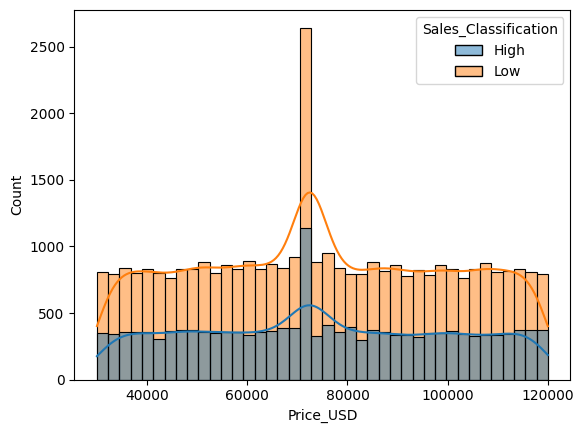

In [35]:
sns.histplot(data = new_df, x = 'Price_USD', hue = 'Sales_Classification', kde = True)

Можем увидеть, что пик по количеству машин в датасете, а также их продаж находится примерно на 70 тысячах. Что в принципе и логично, что самыми продаваемыми и популярными являются средние по цене машины.

<Axes: xlabel='Mileage_KM', ylabel='Count'>

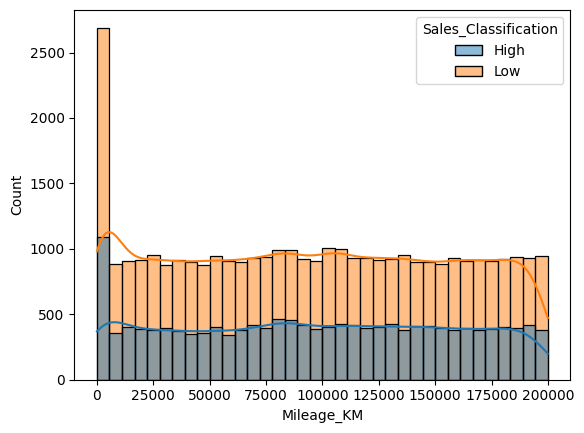

In [36]:
sns.histplot(data=new_df, x = 'Mileage_KM', hue = 'Sales_Classification', kde = True)

Видим скопление количества машин без пробега, а так же, что и самыми продаваемыми, по сравнению с остальными являются именно такие машины. Это логично, так как люди хотят иметь машину без пробега чаще, нежели с пробегом.

<Axes: xlabel='Year', ylabel='Count'>

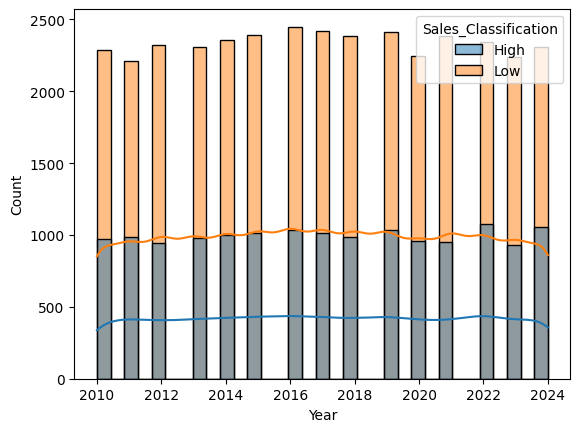

In [37]:
sns.histplot(data = new_df, x = 'Year', hue = 'Sales_Classification', kde = True)

Можем увидеть, что более новые машины более популярны у покупателей и успешнее продаются. Это тоже достаточно логичная зависимость, так как каждому человеку хочется иметь более новую модель машины.

<Axes: xlabel='Sales_Volume', ylabel='Count'>

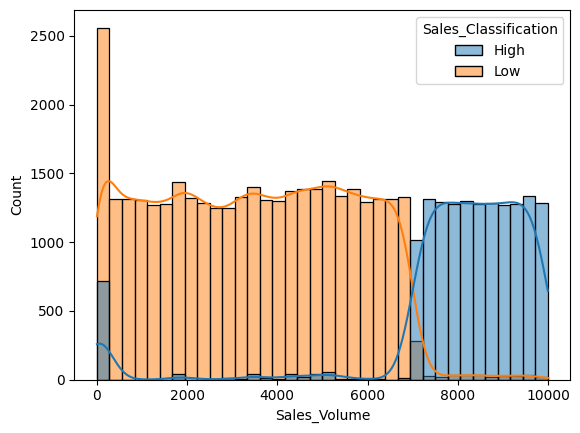

In [38]:
sns.histplot(data = new_df, x = 'Sales_Volume', hue = 'Sales_Classification', kde = True)

Из этого графика можем видеть, что разделением является значение 7000 про продажам, именно с этого момента машины относят к хорошо продаваемым. В большинстве своем преобладают низкие продажи машин, как видим хорошие продажи только лишь в "хвосте".

<Figure size 1000x600 with 0 Axes>

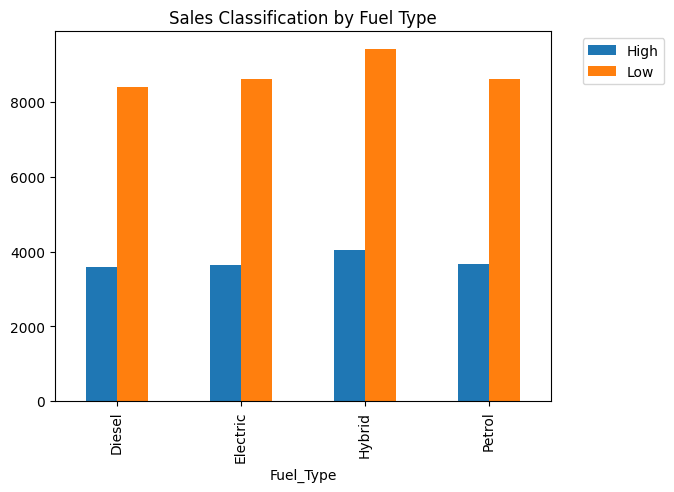

<Figure size 1000x600 with 0 Axes>

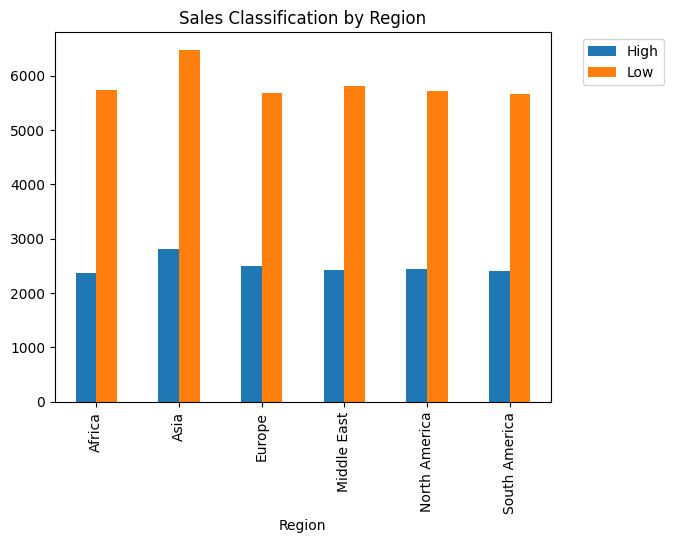

<Figure size 1000x600 with 0 Axes>

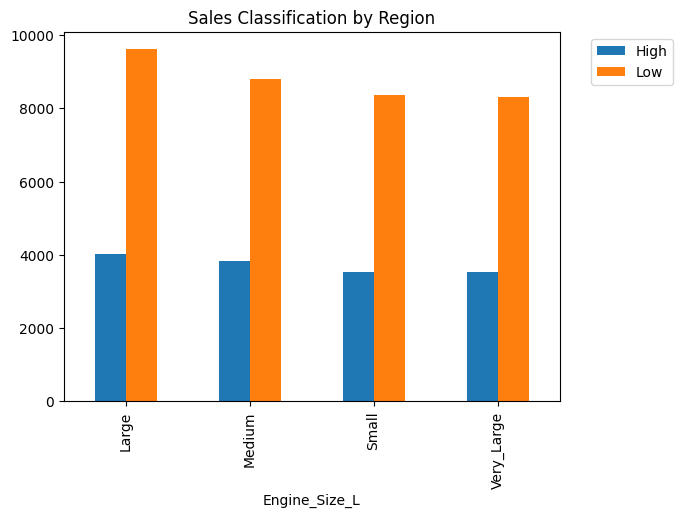

<Figure size 1000x600 with 0 Axes>

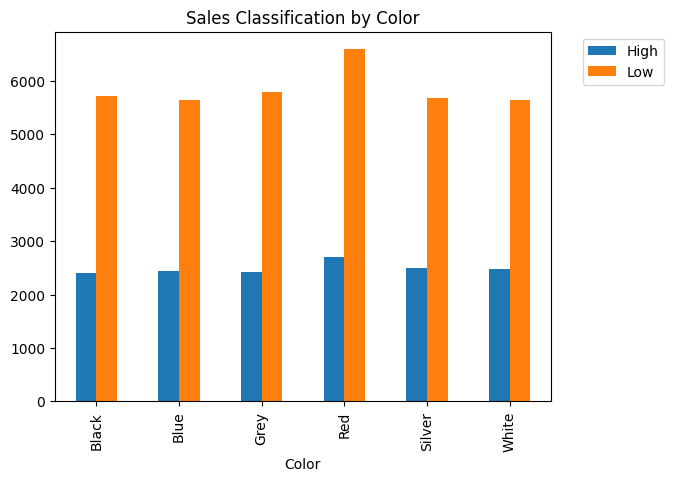

In [39]:
plt.figure(figsize = (10, 6))
pd.crosstab(new_df['Fuel_Type'], new_df['Sales_Classification']).plot(kind = 'bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Sales Classification by Fuel Type')
plt.show()

plt.figure(figsize = (10, 6))
pd.crosstab(new_df['Region'], new_df['Sales_Classification']).plot(kind = 'bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Sales Classification by Region')
plt.show()

plt.figure(figsize = (10, 6))
pd.crosstab(new_df['Engine_Size_L'], new_df['Sales_Classification']).plot(kind = 'bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Sales Classification by Region')
plt.show()

plt.figure(figsize = (10, 6))
pd.crosstab(new_df['Color'], new_df['Sales_Classification']).plot(kind = 'bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Sales Classification by Color')
plt.show()

Как можем увидеть, самыми продаваемыми являются машины с гибридным типом топлива. То есть можно сказать, что это влияющий фактор на продажу машины. Машины с дизельным топливом продаются хуже всего.

Касательно региона можем сказать, что в Азии машины продаются лучше всего. На втором месте стоит Европа. Остальные регионы довольно схожи по продажам, кроме Африки, продажи в которой обстоят хуже всего, что вполне логично, так как уровень развития стран Африки хуже, по сравнению с остальными рассматриваемыми.

Самыми продаваемыми по объему двигателя являются машины с объемом двигателя от (2.3, 4.1).

Самые популярные по продажам цвета - серебристый и белый, в свою очередь черный наименее популярный в продаже цвет.

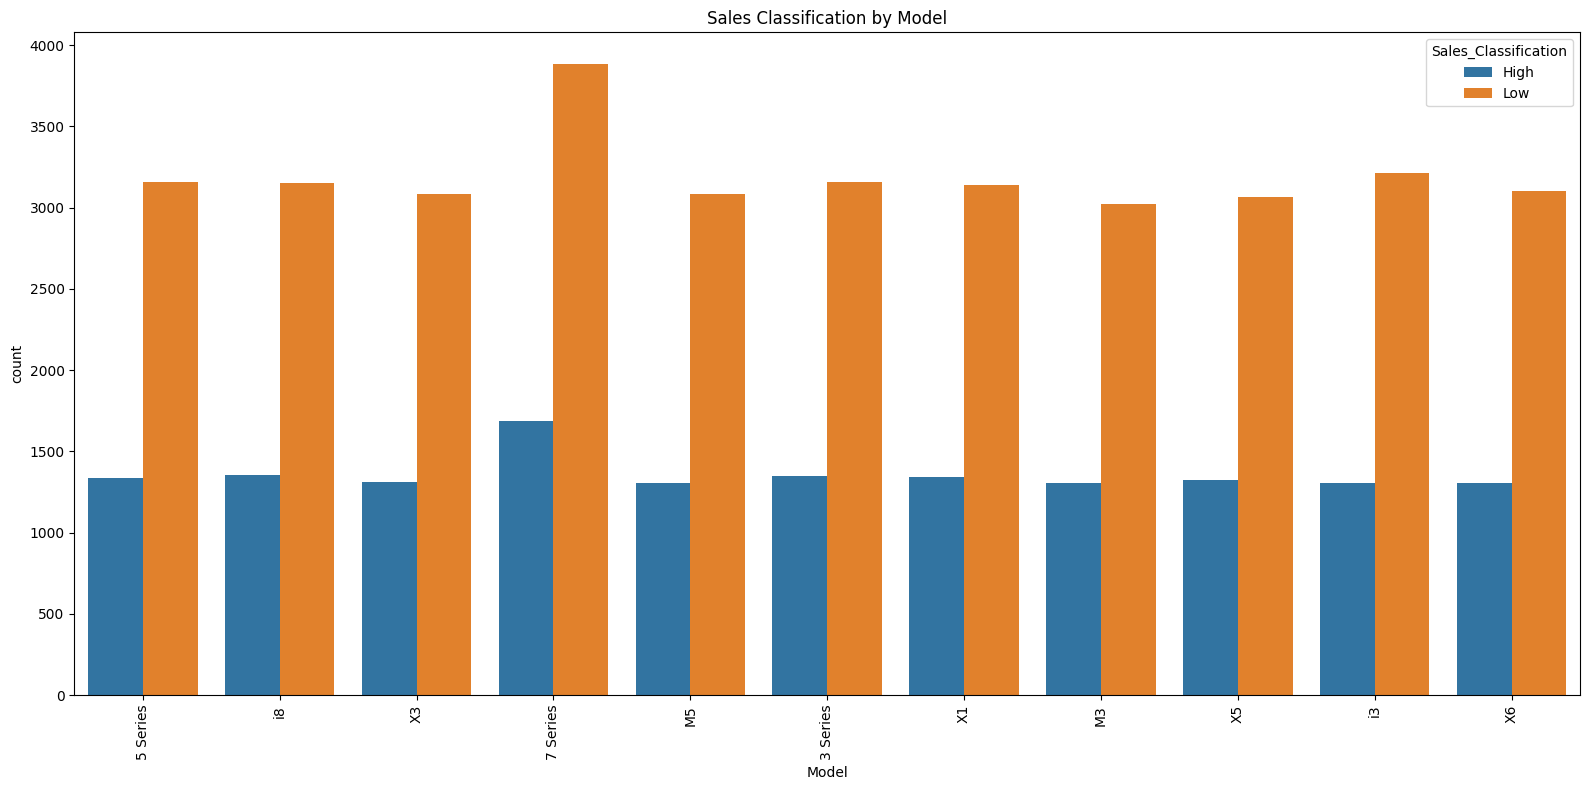

In [40]:
plt.figure(figsize=(16, 8))
sns.countplot(data = new_df, x = 'Model', hue = 'Sales_Classification')
plt.xticks(rotation=90)
plt.title('Sales Classification by Model')
plt.tight_layout()
plt.show()

Как можем видеть, самая продаваемая модель это 7 серия бмв

## Построим матрицу корреляции для числовых данных

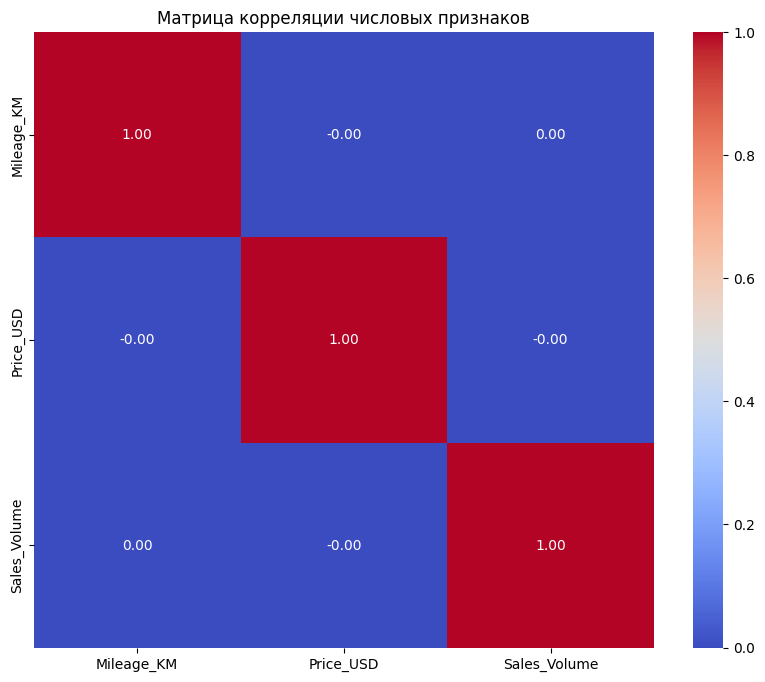

              Mileage_KM  Price_USD  Sales_Volume
Mileage_KM      1.000000  -0.000761      0.001933
Price_USD      -0.000761   1.000000     -0.001008
Sales_Volume    0.001933  -0.001008      1.000000


In [41]:
numeric_cols = ['Mileage_KM', 'Price_USD', 'Sales_Volume']

plt.figure(figsize=(10, 8))
sns.heatmap(new_df[numeric_cols].corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Матрица корреляции числовых признаков')
plt.show()
print(new_df[numeric_cols].corr())

Так как корреляции нулевые можем увидеть, что зависимости не линейные.

## Посмотрим остальные зависимости

<Axes: xlabel='Price_USD', ylabel='Sales_Volume'>

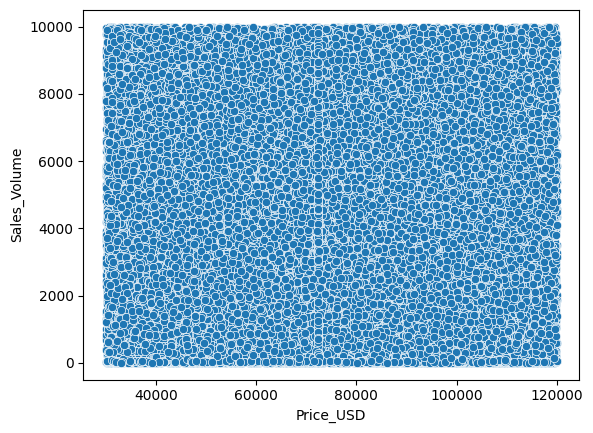

In [42]:
sns.scatterplot(data = new_df, x = 'Price_USD', y = 'Sales_Volume')

Как можем увидеть, какой-то зависимости не проглядывается, все точки равномерно покрывают нашу плоскость, следовательно линейной зависимости продаж от цены не наблюдается. Значит поищем закономерности еще.

<Figure size 1000x600 with 0 Axes>

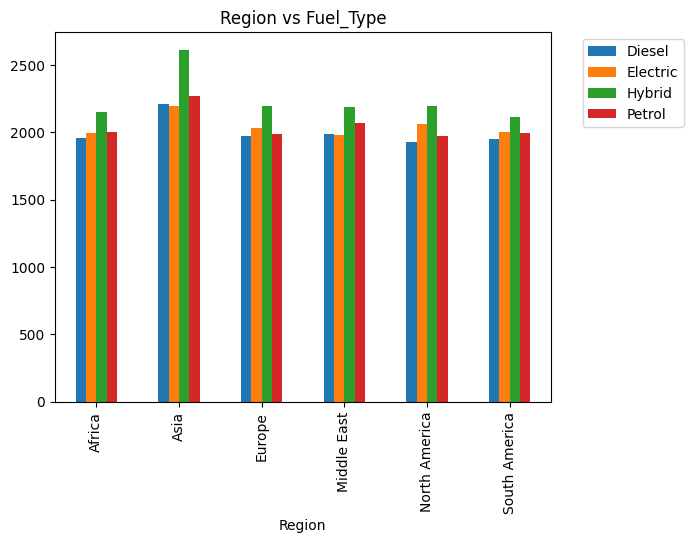

<Figure size 1000x600 with 0 Axes>

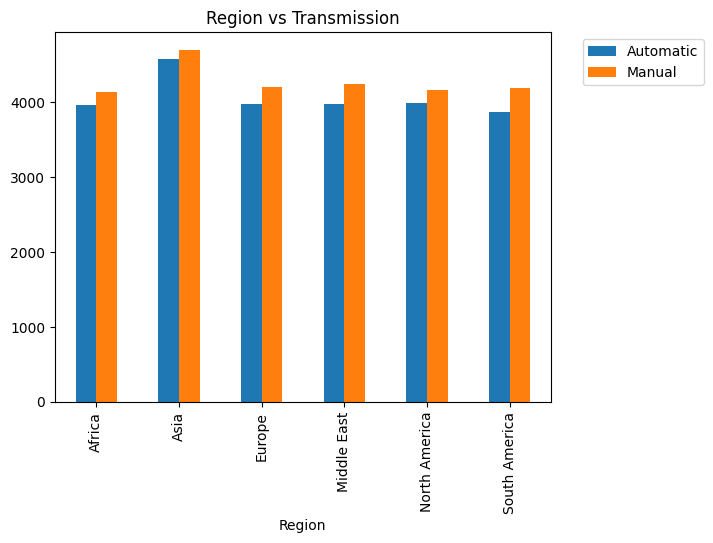

<Figure size 1000x600 with 0 Axes>

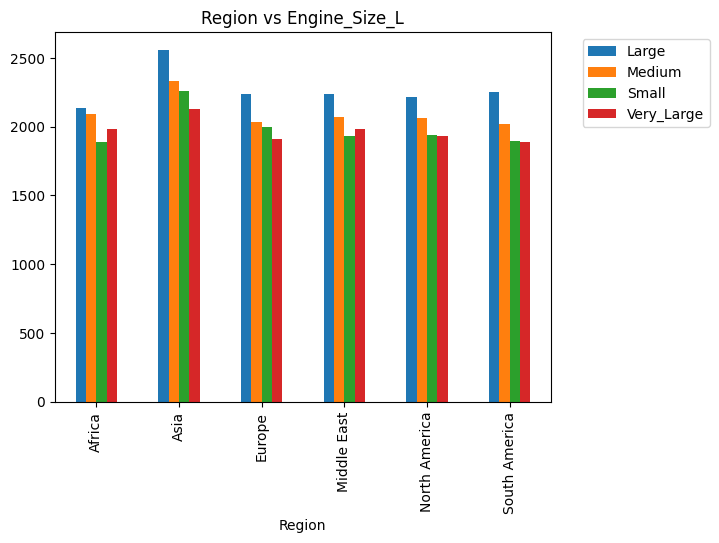

<Figure size 1000x600 with 0 Axes>

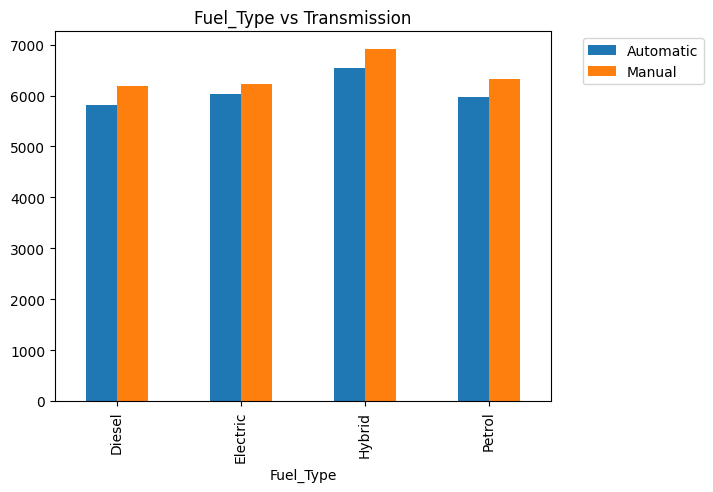

<Figure size 1000x600 with 0 Axes>

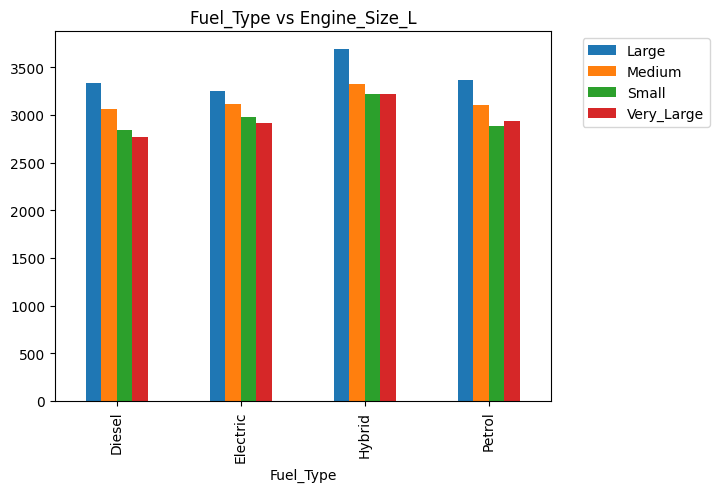

<Figure size 1000x600 with 0 Axes>

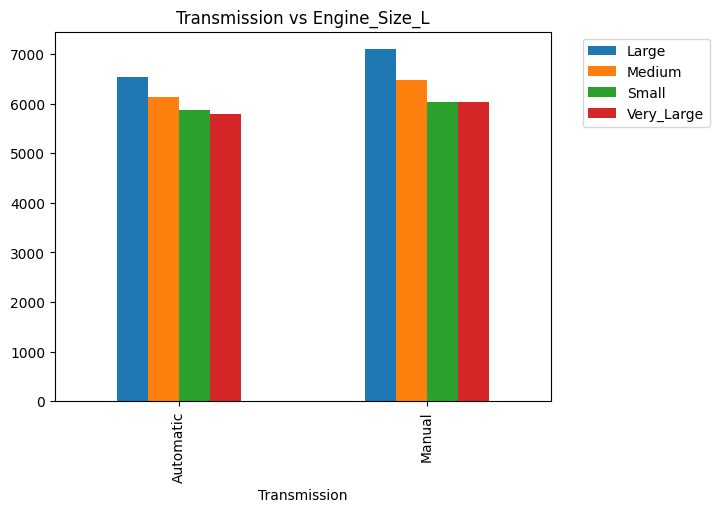

In [43]:
cat_cols = ['Region', 'Fuel_Type', 'Transmission', 'Engine_Size_L']

for i in range(len(cat_cols)):
    for j in range(i + 1, len(cat_cols)):
        plt.figure(figsize = (10, 6))
        pd.crosstab(new_df[cat_cols[i]], new_df[cat_cols[j]]).plot(kind = 'bar')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f'{cat_cols[i]} vs {cat_cols[j]}')
        plt.show()

Как можем видеть, ранее полученные закономерности сохраняются. Как и ранее, можем заметить, что Азиатский регион является лидирующим по продажам машин, и самым популярным типом двигателей является Гибрид. Также очень интересным наблюдением является то, что в регионах Америки и Европы электрокары становятся более распространены, чем машины на бензине. На Ближнем Востоке ситуация обратная.

В общем можем сказать, что регион не влияет на тип трансмиссии. Больше берут машин с механикой.

Самыми популярными машинами среди всех регионов являются машины с объемом двигателя от 2.2 до 4 литров, однако стоит отметить, что в странах Ближнего Востока и Африки вторыми по популярности являются машины с двигателем больше 4 литров, а не маленькие. Этому есть логическое объяснение, так как многие жители этих стран используют машины для езды по бездорожью из-за чего может потребоваться двигатель помощнее.

Во всех регионах мира популярнее механика.

Размер двигателя размерами от 2.2 до 4 самый популярный среди всех водителей машин, вне зависимости от типа трансмиссии и типа топлива.


In [44]:
new_df.head()

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,Large,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,Small,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,Very_Large,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,Small,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,Small,122131,49898,3080,Low


# Деление на тренировочный/тестирующий датасет

Разделим датасет на обучающий и тестирующий датасет

In [45]:
X = new_df.drop('Sales_Classification', axis = 1)
y = new_df['Sales_Classification'].map({'Low': 0, 'High': 1}).values

categorical = ['Model', 'Region', 'Color', 'Fuel_Type', 'Transmission', 'Engine_Size_L']
numeric = ['Year', 'Mileage_KM', 'Price_USD', 'Sales_Volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

Затем закодируем с помощью OHE наши категориальные данные.

In [46]:
cd = OneHotEncoder(drop = 'first', sparse_output = False)
X_train_cd = cd.fit_transform(X_train[categorical])
X_test_cd = cd.transform(X_test[categorical])

Численные данные нормируем обычным скейлером.

In [47]:
scl = StandardScaler()
X_train_scl = scl.fit_transform(X_train[numeric])
X_test_scl = scl.transform(X_test[numeric])

Соединяем назад закодированные категориальные данные и нормированные численные.

In [48]:
X_train_f = np.concatenate([X_train_cd, X_train_scl], axis = 1)
X_test_f = np.concatenate([X_test_cd, X_test_scl], axis = 1)

Сначала обучаем наши модели на данных без уменьшения размерности. Применим модель логистической регрессии, метод опорных векторов и случайный лес. После этого используем метод score для оценки успеха обучения модели.  

In [49]:
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train_f, y_train)
    test_score = model.score(X_test_f, y_test)
    print(f"{name}: {test_score:.3f}")

Logistic Regression: 0.964
SVM: 0.961
Random Forest: 0.979


После этого используем три вида понижения размерности L1-регуляризацию, SFS и дерево решений. Последовательно используя понижение размерности, так же обучим три модели и снова посмотрим успешность обучения при помощи метода score.

In [50]:
reduction_methods = {
    'L1': SelectFromModel(LogisticRegression(penalty = 'l1', solver = 'liblinear')),
    'Tree_importance': SelectFromModel(DecisionTreeClassifier()),
    'SFS': SequentialFeatureSelector(LogisticRegression(), n_features_to_select = 10, direction = 'forward', cv = 2, n_jobs =- 1)
}

for reduction_name, reducer in reduction_methods.items():
    print(f"\n{reduction_name}:")
    X_train_reduced = reducer.fit_transform(X_train_f, y_train)
    X_test_reduced = reducer.transform(X_test_f)

    for model_name, model in models.items():
        model.fit(X_train_reduced, y_train)
        score = model.score(X_test_reduced, y_test)
        print(f"{model_name}: {score:.3f}")


L1:
Logistic Regression: 0.964
SVM: 0.962
Random Forest: 0.982

Tree_importance:
Logistic Regression: 0.964
SVM: 0.970
Random Forest: 0.985

SFS:
Logistic Regression: 0.964
SVM: 0.967
Random Forest: 0.986


# Вывод

В результате получили, что лучший результат без уменьшения размерности показывает модель случайного леса. Можем сделать вывод, что данные содержат какие-то взаимодействия между признаками. Логистическая регрессия и метод опорных векторов дали примерно одинаковый результат.

После уменьшения размерности можем увидеть, что лучший результат по-прежнему сохраняется у случайного леса. Так же следует отметить, что метод уменьшения разверности при помощи дерева решений даёт результат лучше для опорных векторов.

Так же хочется сказать, что в целом все три модели показывают очень хороший результат без выбора каких-либо начальных параметров.

# Задание 2


# Понижение размерности


In [51]:
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_f)
X_test_pca = pca.transform(X_test_f)

In [52]:
lda = LinearDiscriminantAnalysis(n_components = 1)
X_train_lda = lda.fit_transform(X_train_f, y_train)
X_test_lda = lda.transform(X_test_f)

In [53]:
tsne = TSNE(n_components = 2, random_state = 42, perplexity = 30)
X_train_tsne = tsne.fit_transform(X_train_f[:5000])

Далее рассматривать влияение понижения размерности будем на показавшей себя лучше всего модели, а конкретно - Random Forest.

In [54]:
rf = RandomForestClassifier()

In [55]:
rf.fit(X_train_f, y_train)
acc_original = accuracy_score(y_test, rf.predict(X_test_f))

rf.fit(X_train_pca, y_train)
acc_pca = accuracy_score(y_test, rf.predict(X_test_pca))

rf.fit(X_train_lda, y_train)
acc_lda = accuracy_score(y_test, rf.predict(X_test_lda))

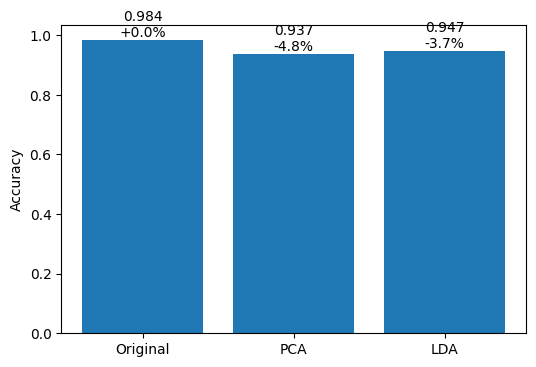

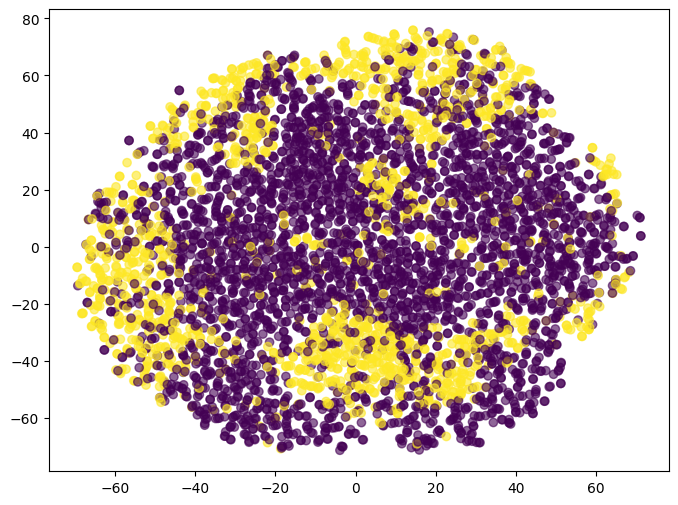

In [56]:
plt.figure(figsize = (6, 4))
plt.bar(['Original', 'PCA', 'LDA'], [acc_original, acc_pca, acc_lda])
plt.ylabel('Accuracy')
for i, v in enumerate([acc_original, acc_pca, acc_lda]):
    diff_pct = (v/acc_original - 1) * 100
    plt.text(i, v+0.01, f'{v:.3f}\n{diff_pct:+.1f}%', ha = 'center')
plt.show()


plt.figure(figsize = (8, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c = y_train[:5000], alpha = 0.6)
plt.show()

Сделаем выводы, полученные из данных рисунков и рассчетов. Как можно увидеть, естественно оригинальная модель по прежнему остается самой точной, что и логично, так как никакой потери в данных мы не несем. LDA продемонстрировала нам потерю в ~3.5%, но нужно понимать, что мы сократили данные до одного признака, что показывает, что наша задача неплохо линеаризуется.

В свою очередь PCA теряет почти 5% данных, что на фоне нашего эксперимента уже достаточно много, поэтому данный метод в этом случае работает хуже.

t-SNE продемонстрировал нам на 50000 данных, что деление на некоторые кластеры присутсвуют, причем стоит отметить, что деление вовсе необычное. Можно заметить, что получается силуэт чем-то похожий на вложенные друг в друга кольцо. Можно сделать вывод, что классы нехорошо линейно разделимы, но имеют определенную структуру.

# Кластеризация

Применяем K-Means к PCA

In [57]:
kmeans_pca = KMeans(n_clusters = 2, random_state = 42)
kmeans_labels_pca = kmeans_pca.fit_predict(X_train_pca)

Применяем K-Means к LDA

In [58]:
kmeans_lda = KMeans(n_clusters=2, random_state=42)
kmeans_labels_lda = kmeans_lda.fit_predict(X_train_lda.reshape(-1, 1))

Применяем K-Means к оригинальным данным

In [59]:
kmeans_orig = KMeans(n_clusters = 2, random_state = 42)
kmeans_labels_orig = kmeans_orig.fit_predict(X_train_f)

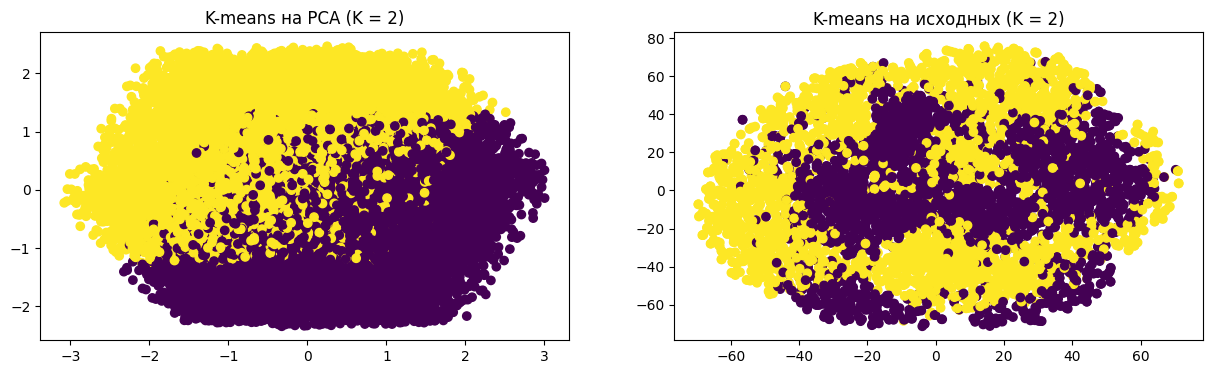

In [60]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c = kmeans_labels_pca, cmap = 'viridis')
axes[0].set_title('K-means на PCA (K = 2)')

axes[1].scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c = kmeans_labels_orig[:5000], cmap = 'viridis')
axes[1].set_title('K-means на исходных (K = 2)')

plt.show()

Как можем видеть, K-Means на PCA показывает почти красивое разделение ровно напополам, только внутри какая-то "кашица", то есть кластеризация на главных компонентах очень хорошая. На исходных K-Means показывает тот же самый рисунок, что и на t-SNE.

Применяем DBSCAN к оригинальным данным

In [61]:
sample_size = 4000
np.random.seed(42)
sample_idx = np.random.choice(len(X_train_f), sample_size, replace=False)
X_sample = X_train_f[sample_idx]


dbscan = DBSCAN(
    eps=5,
    min_samples=10,
    algorithm='ball_tree', 
    leaf_size=30,
    n_jobs=-1  
)
dbscan_labels = dbscan.fit_predict(X_sample)
dbscan_labels_f = dbscan.fit_predict(X_train_f)

Text(0.5, 1.0, 'DBSCAN (кластеров: 0)')

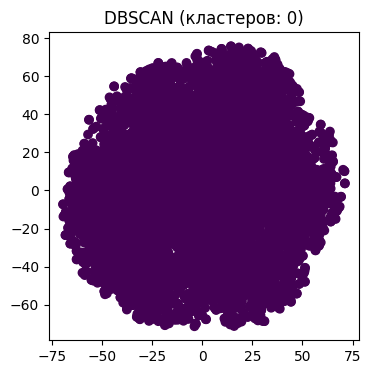

In [62]:
fig, axes = plt.subplots(1, figsize = (4, 4))

axes.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c = dbscan_labels_f[:5000], cmap = 'viridis')
axes.set_title(f'DBSCAN (кластеров: {len(set(dbscan_labels))-1})')

In [63]:
from sklearn.metrics import adjusted_rand_score

print(f"K-means (PCA):     ARS = {adjusted_rand_score(y_train, kmeans_labels_pca):.3f}")
print(f"K-means (original): ARS = {adjusted_rand_score(y_train, kmeans_labels_orig):.3f}")
print(f"DBSCAN:            ARS = {adjusted_rand_score(y_train[sample_idx], dbscan_labels):.3f}")

K-means (PCA):     ARS = 0.278
K-means (original): ARS = 0.277
DBSCAN:            ARS = 0.000


Можно сделать следующие выводы исходя из проделанной работы. K-Means на PCA и оригинальных данных показал плохое совпадение с целевой переменной. Скорее всего есть какие-то более сложные закономерности, чем просто бинарная классификация. Так же можем сказать, есть после уменьшения размерности K-Means на PCA и оригинальных данных показал себя одинаково. DBSCAN так и не смог показать какого-то деления на кластеры.

# Оценить производительность модели

In [64]:
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(random_state = 42, n_estimators = 100)
cv_scores = cross_val_score(rf, X_train_f, y_train, cv = 5)

print(f"CV Accuracy: {cv_scores.mean():.4f}")
print(f"Fold scores: {cv_scores}")

CV Accuracy: 0.9824
Fold scores: [0.985625 0.979625 0.9805   0.98225  0.983875]


Как видим, кросс-валидация показала совпадение почти на 98%, что говорит нам о стабильности модели. 

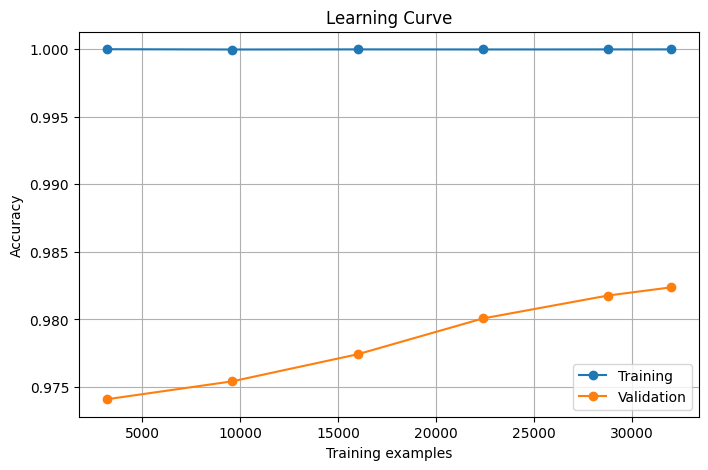

In [65]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    rf, X_train_f, y_train, cv = 5, train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
) 

plt.figure(figsize = (8, 5))
plt.plot(train_sizes, train_scores.mean(axis = 1), 'o-', label = 'Training')
plt.plot(train_sizes, val_scores.mean(axis = 1), 'o-', label = 'Validation')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

График показывает идеальную ситуацию. Тренировочная кривая постоянно на единичке, то есть модель отлично запоминает данные, в свою очередь точность на новых данных начинает планомерно расти, при этом приближаясь к значению 0.982 как раз показывая, что она выходит на плато. Модель почти идеальна на этих данных и не требует улучшения.

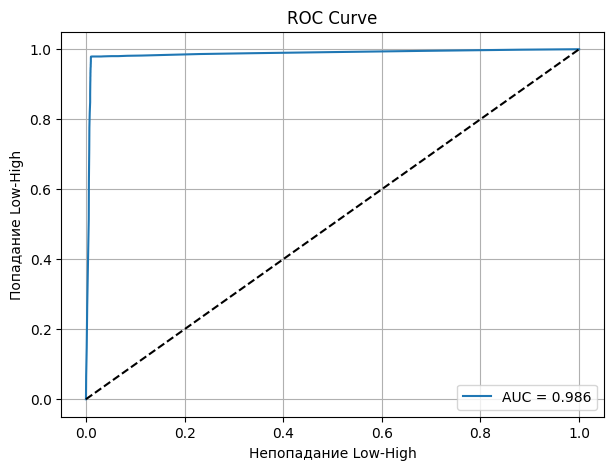

AUC: 0.9863


In [66]:
from sklearn.metrics import roc_curve, auc

rf.fit(X_train_f, y_train)
y_proba = rf.predict_proba(X_test_f)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (7, 5))
plt.plot(fpr, tpr, label = f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Непопадание Low-High')
plt.ylabel('Попадание Low-High')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC: {roc_auc:.4f}")

Получили, что площадь под ROC кривой почти 1, то есть наша модель идеально отличает целевую переменную при бинарной классификации.

# Подбор гипер-параметров

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state = 42)

grid_search = GridSearchCV(
    rf, param_grid, cv = 3, 
    scoring = 'accuracy', n_jobs = -1, verbose = 1
) 

grid_search.fit(X_train_f, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Лучшие параметры: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Лучший accuracy: 0.9828750349777193


# AdaBoost и XGBoost

In [68]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

ada = AdaBoostClassifier(n_estimators = 100, random_state = 42)
ada.fit(X_train_f, y_train)
y_pred_ada = ada.predict(X_test_f)
acc_ada = accuracy_score(y_test, y_pred_ada)

xgb = XGBClassifier(n_estimators = 100, random_state = 42,)

xgb.fit(X_train_f, y_train)
y_pred_xgb = xgb.predict(X_test_f)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"AdaBoost accuracy: {acc_ada:.4f}")
print(f"XGBoost accuracy: {acc_xgb:.4f}")

AdaBoost accuracy: 0.9863
XGBoost accuracy: 0.9817


Как можем увидеть, данные модели показали себя лучше, чем логистическая регрессия и SVM. В свою очередь RandomForest с SFS показывает сравнимый с этими моделями результат 0.986, однако та же модель случайных лесов на оптимальных параметрах дает меньшую точность 0.982. Так же стоит отметить, что AdaBoost показал себя лучше на 0.005, чем XGBoost. Это может сказать нам о том, что возможно данные не так сложны, поэтому такая сложная модель как XGB переизбыточна по сравнению с AdaBoost.